In [1]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('../data/nfp2/nfp2.db')  # Adjust the path to your database file

# Step 2 & 3: Query the database and load the data into a pandas DataFrame
query = "SELECT * FROM stellarators"  # Adjust your query as needed
data_df = pd.read_sql_query(query, conn)

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV

data_df_clean = data_df.dropna(subset=['maximum_elongation'])

X = data_df_clean[['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1','zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']] 
Y = data_df_clean[['quasisymmetry', 'quasiisodynamic', 'rotational_transform', 'inverse_aspect_ratio', 'mean_local_magnetic_shear', 'vacuum_magnetic_well', 'maximum_elongation', 'mirror_ratio']]

target = Y['maximum_elongation']
features = X

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print(features.shape)
print(target.shape)


(165822, 8)
(165822,)


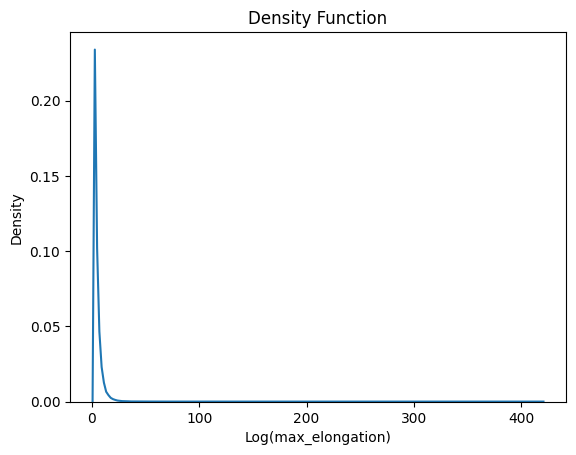

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.kdeplot((target), bw_adjust=0.5)
plt.title('Density Function')
plt.xlabel('Log(max_elongation)')
plt.ylabel('Density')
plt.show()


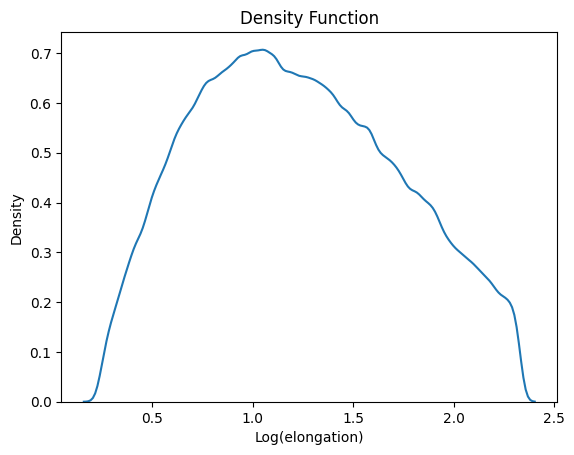

In [4]:
# now i want to eliminate the outliers

q1 = target.quantile(0.25)
q3 = target.quantile(0.75)

# Calculate the interquartile range (IQR)
iqr = q3 - q1

# Define bounds for what is considered an outlier
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter the data to remove outliers
target_no_outliers = Y_train[(Y_train >= lower_bound) & (Y_train <= upper_bound)]
features_no_outliers = X_train.loc[target_no_outliers.index]

sns.kdeplot(np.log(target_no_outliers), bw_adjust=0.5)
plt.title('Density Function')
plt.xlabel('Log(elongation)')
plt.ylabel('Density')
plt.show()

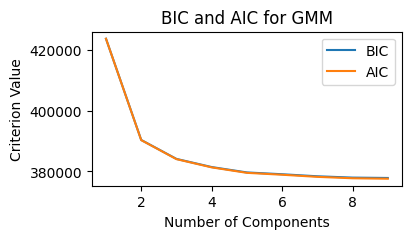

Selected Model Components: 9


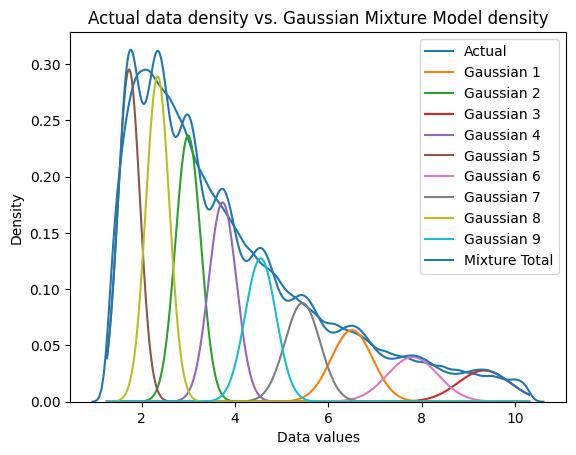

In [5]:
from sklearn.mixture import GaussianMixture

from scipy.stats import norm

X_train, X_test, Y_train, Y_test = train_test_split(features_no_outliers, target_no_outliers, test_size=0.2, random_state=42)


# Assuming `Y_train_np` is your 1D numpy array data
Y_train_np = Y_train.to_numpy().reshape(-1, 1)  # Reshape to 2D if necessary

# Use AIC and BIC to determine the best number of components for GMM
n_components_range = range(1, 10)  # Example range, can be adjusted
lowest_bic = np.infty
lowest_aic = np.infty
best_gmm = None
bic = []
aic = []

for n_components in n_components_range:
    # Fit a Gaussian mixture with n components
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(Y_train_np)
    
    # Calculate the BIC and AIC
    bic.append(gmm.bic(Y_train_np))
    aic.append(gmm.aic(Y_train_np))
    
    # Determine if this model has the lowest BIC
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm_bic = gmm
        
    # Determine if this model has the lowest AIC
    if aic[-1] < lowest_aic:
        lowest_aic = aic[-1]
        best_gmm_aic = gmm

# Plot the BIC scores
plt.figure(figsize=(4, 2))
plt.plot(n_components_range, bic, label='BIC')
plt.plot(n_components_range, aic, label='AIC')
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Criterion Value')
plt.title('BIC and AIC for GMM')
plt.show()

# Use the best model for the final density plot
best_gmm = best_gmm_bic if lowest_bic < lowest_aic else best_gmm_aic
print(f"Selected Model Components: {best_gmm.n_components}")

# Generate some data points for plotting the density
x = np.linspace(Y_train_np.min(), Y_train_np.max(), 1000).reshape(-1, 1)
logprob = best_gmm.score_samples(x)
responsibilities = best_gmm.predict_proba(x)
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

# Plot the actual kernel density estimation of your data
sns.kdeplot(Y_train_np.flatten(), bw_adjust=0.5, label='Actual')

# Plot each component density
for i in range(best_gmm.n_components):
    plt.plot(x, pdf_individual[:, i], label=f'Gaussian {i+1}')

# Plot the total density
plt.plot(x, pdf, label='Mixture Total')

plt.legend()
plt.title('Actual data density vs. Gaussian Mixture Model density')
plt.xlabel('Data values')
plt.ylabel('Density')
plt.show()


/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fitting of candidate distributions completed: 100%|██████████| 8/8 [00:16<00:00,  2.06s/it]


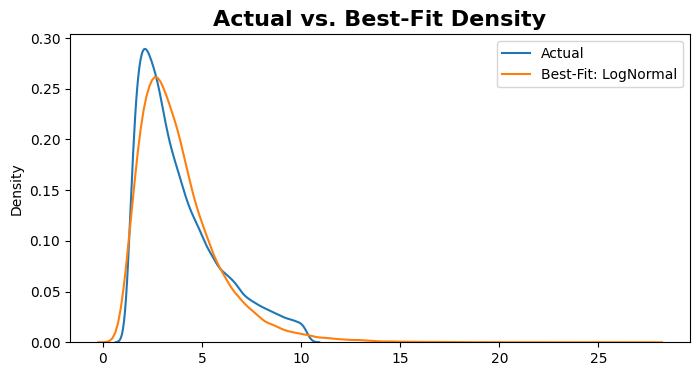

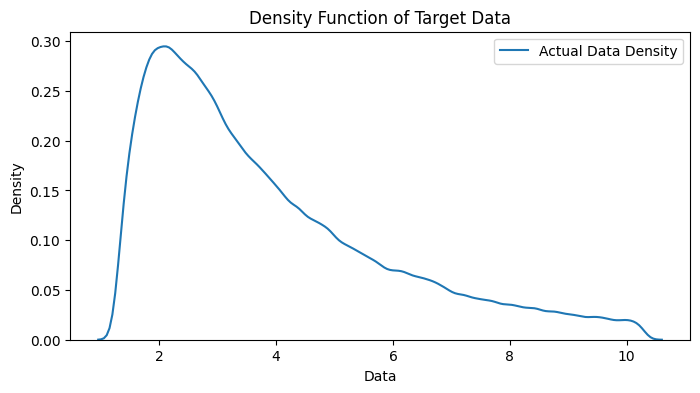

In [6]:
from lightgbmlss.distributions import *
from lightgbmlss.distributions.distribution_utils import DistributionClass
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Your data preparation steps
Y_train_np = np.array(Y_train)

lgblss_dist_class = DistributionClass()
candidate_distributions = [Gaussian, StudentT, Gamma, Cauchy, LogNormal, Weibull, Gumbel, Laplace]

# Selecting the best distribution based on negative log-likelihood
dist_nll = lgblss_dist_class.dist_select(target=Y_train_np, candidate_distributions=candidate_distributions, max_iter=50, plot=True, figure_size=(8, 4))
dist_nll

# Plot the actual data density
plt.figure(figsize=(8, 4))
sns.kdeplot(Y_train_np, bw_adjust=0.5, label='Actual Data Density')
plt.title('Density Function of Target Data')
plt.xlabel('Data')
plt.ylabel('Density')
plt.legend()
plt.show()


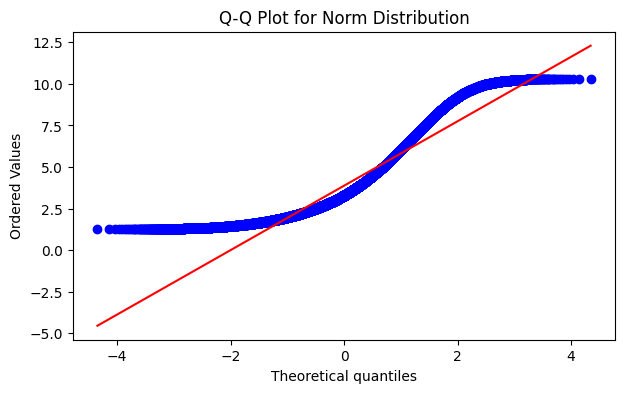

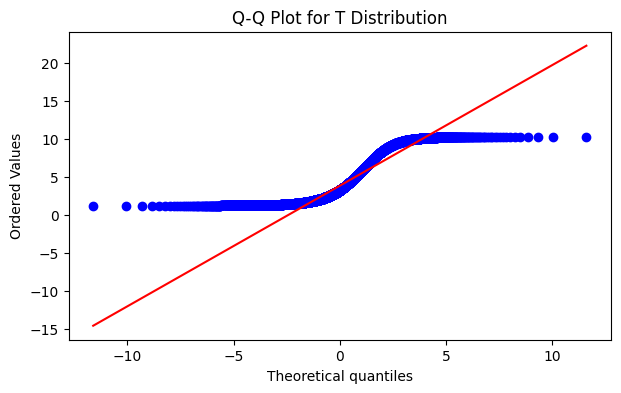

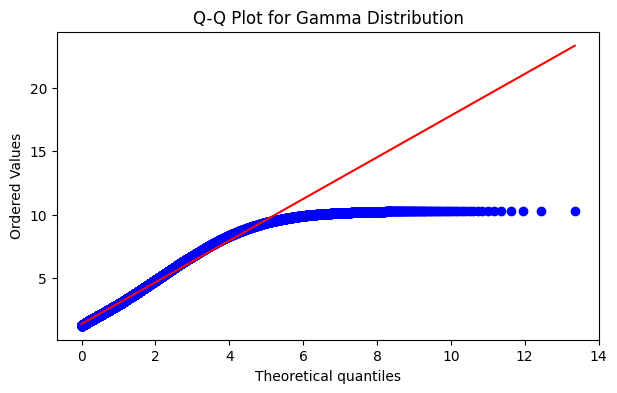

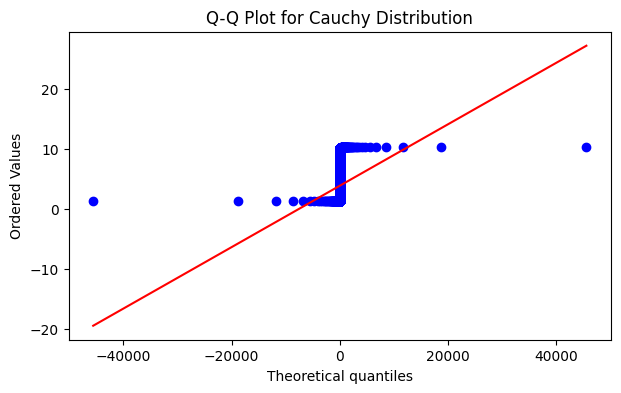

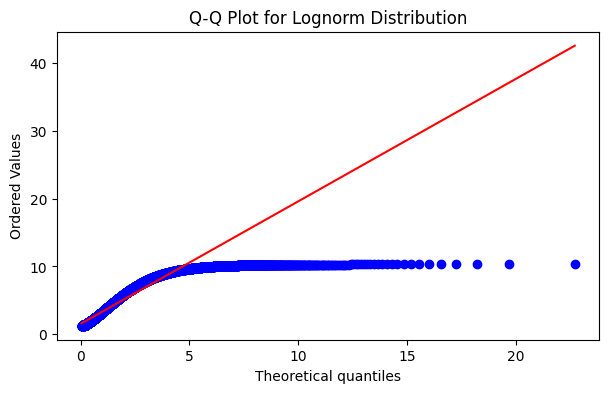

In [7]:
from scipy import stats
import matplotlib.pyplot as plt

# Assuming Y_train_np is your data
distributions = {
    'norm': stats.norm, 
    't': stats.t, 
    'gamma': stats.gamma, 
    'cauchy': stats.cauchy, 
    'lognorm': stats.lognorm,
}

for name, dist in distributions.items():
    # Fit the distribution to your data
    params = dist.fit(Y_train_np)
    
    # Generate Q-Q plot
    plt.figure(figsize=(7, 4))
    stats.probplot(Y_train_np, dist=name, sparams=params[:-2], plot=plt)
    plt.title(f'Q-Q Plot for {name.capitalize()} Distribution')
    plt.show()


este grafico apenas ve a distribuição da target variable?

In [8]:
from lightgbmlss.model import *
from lightgbmlss.distributions.Gaussian import *

dtrain = lgb.Dataset(X_train, label=Y_train.values)  # Convert to numpy array

lgblss = LightGBMLSS(
    Gaussian(stabilization="None",  
             response_fn="exp",      
             loss_fn="nll"          
            ))

param_dict = { 
    "max_depth":               ["int",   {"low": 1,    "high": 10,    "log": False}],
    "num_leaves":              ["int",   {"low": 2,    "high": 100,   "log": False}],  
    "min_data_in_leaf":        ["int",   {"low": 200,  "high": 200,   "log": False}],  
    "min_gain_to_split":       ["float", {"low": 1, "high": 40,    "log": False}],
    "min_sum_hessian_in_leaf": ["float", {"low": 1, "high": 500,   "log": True}],
    "subsample":               ["float", {"low": 0.2,  "high": 1.0,   "log": False}],
    "feature_fraction":        ["float", {"low": 0.2,  "high": 1.0,   "log": False}],
    "boosting":                ["numerical", ["dart", "goss", "gbdt"]],
}

np.random.seed(123)
opt_param = lgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=50,   # Number of early-stopping rounds
                             max_minutes=10,             # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=30 ,               # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=True,               # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=123                 # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

Best trial: 12. Best value: 31568.3: 100%|██████████| 30/30 [03:59<00:00,  7.97s/it, 239.09/600 seconds]


Hyper-Parameter Optimization successfully finished.
  Number of finished trials:  30
  Best trial:
    Value: 31568.29083213995
    Params: 
    max_depth: 10
    num_leaves: 71
    min_data_in_leaf: 200
    min_gain_to_split: 1.195199227873034
    min_sum_hessian_in_leaf: 1.9152683188294102
    subsample: 0.9847871440109739
    feature_fraction: 0.8376217072921396
    boosting: gbdt
    opt_rounds: 100


In [9]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
lgblss.train(opt_params, dtrain, num_boost_round=n_rounds)

# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
quant_sel = [0.05, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = lgblss.predict(X_test,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = lgblss.predict(X_test,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Return predicted distributional parameters
pred_params = lgblss.predict(X_test,
                             pred_type="parameters")

In [10]:
pred_samples.head()

y_sample0  y_sample1  y_sample2  y_sample3  y_sample4  y_sample5  \
0   2.173368   3.210806   1.316367   1.923620   3.001768   1.638571   
1   2.615838   3.647395   2.527113   2.797931   2.761167   1.747549   
2   3.247141   3.121039   1.991219   4.326376   2.140528   2.977310   
3   2.503713   2.698100   1.630362   3.543967   5.260767   3.612562   
4   1.694686   1.313299   1.514174   1.434557   1.755501   1.551992   

   y_sample6  y_sample7  y_sample8  y_sample9  ...  y_sample990  y_sample991  \
0   1.159541   2.791613   0.881180   2.148884  ...     1.971910     1.837902   
1   1.546190   1.747622   2.335678   3.407830  ...     2.044151     2.447274   
2   3.908542   0.922631   2.070208   3.479996  ...     4.798753     1.233491   
3   1.349935   5.118656   4.005520   2.325987  ...     1.719847     2.202080   
4   1.340638   1.623403   1.578810   1.544075  ...     2.181004     1.977814   

   y_sample992  y_sample993  y_sample994  y_sample995  y_sample996  \
0     1.517008     1.685908     2.045133     2.579215     2.334181   
1     2.296026     2.364799     2.593842     2.026828     0.629627   
2     4.123165     1.014873     4.683574     2.189190     2.550272   
3     2.514895     2.978009     3.922216     1.693486     3.431269   
4     1.614522     1.621448     1.696160     1.286632     1.647519   

   y_sample997  y_sample998  y_sample999  
0     2.714091     2.433215     1.706406  
1     2.651615     3.145187     3.185110  
2     5.319330     3.188438     3.103511  
3     3.108234     0.605830     2.889419  
4     1.731649     1.005170     1.408404  

[5 rows x 1000 columns]

In [11]:
pred_quantiles.head()

quant_0.05  quant_0.95
0    1.001807    2.921575
1    1.645983    3.957526
2    1.207353    5.876354
3    1.246658    5.392451
4    1.161638    1.993016

In [12]:
pred_params.head()

loc     scale
0  1.974203  0.590345
1  2.742109  0.710279
2  3.675432  1.411047
3  3.268035  1.299842
4  1.608261  0.247917

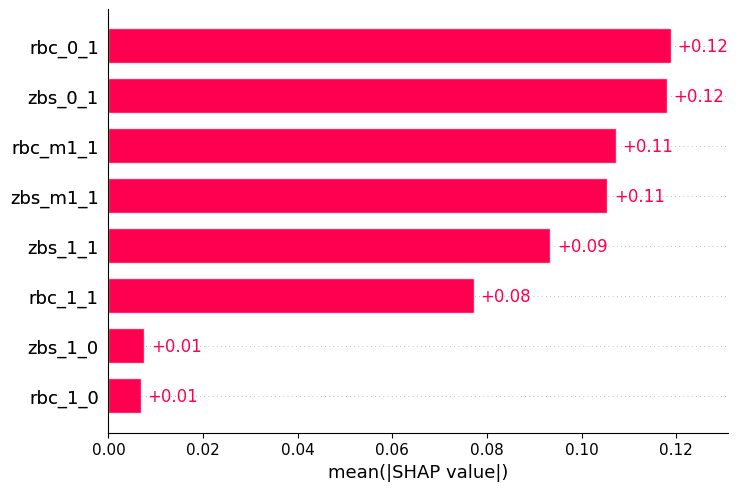

In [13]:
# Feature Importance of scale parameter
lgblss.plot(X_test,
            parameter="scale",
            plot_type="Feature_Importance")

In [14]:
predicted_means = pred_params['loc']
predicted_variances = pred_params['scale']

predicted_std = np.sqrt(predicted_variances)

mean_error = np.mean(np.abs(predicted_means - Y_test))

# mean_squared_error = np.mean((predicted_means - Y_test) ** 2)

# Output the results
print(f"Mean Error (MAE): {mean_error}")
print(f"Standard Deviation: {predicted_std.mean()}")  # Average standard deviation across all predictions


Mean Error (MAE): 1.8091053679061466
Standard Deviation: 1.0719488859176636


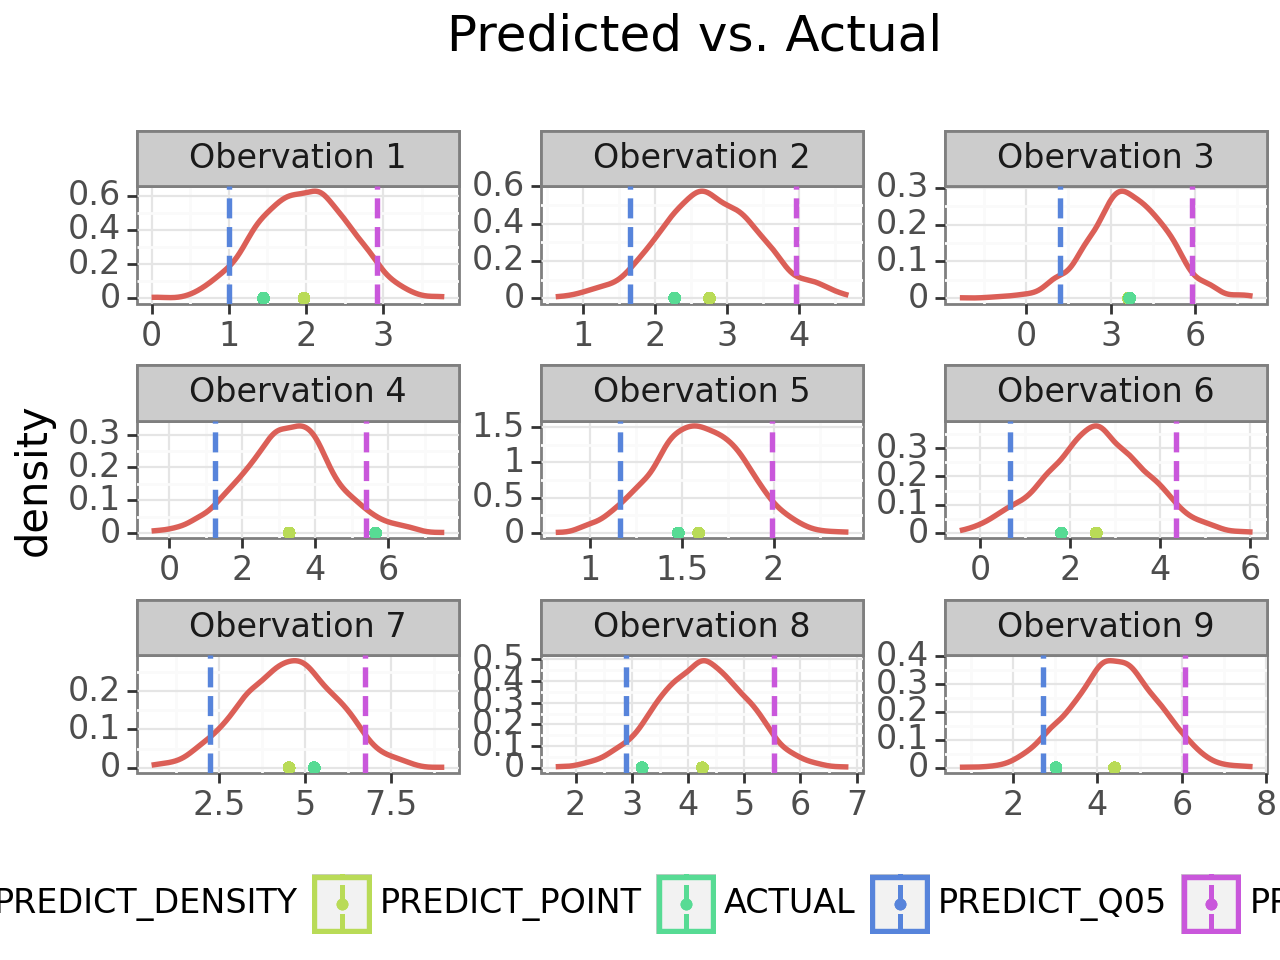

In [15]:
from plotnine import ggplot, aes, geom_point, geom_vline, stat_density, facet_wrap, labs, theme_bw, scale_fill_brewer, theme, element_text, element_blank

y_pred = []

n_examples = 9

for i in range(n_examples):    
    y_samples = pd.DataFrame(pred_samples.values[i,:].reshape(-1,1), columns=["PREDICT_DENSITY"])
    y_samples["PREDICT_POINT"] = y_samples["PREDICT_DENSITY"].mean()
    y_samples["PREDICT_Q05"] = y_samples["PREDICT_DENSITY"].quantile(q=quant_sel[0])
    y_samples["PREDICT_Q95"] = y_samples["PREDICT_DENSITY"].quantile(q=quant_sel[1])
    y_samples["ACTUAL"] = Y_test.iloc[i]
    y_samples["obs"]= f"Obervation {i+1}"
    y_pred.append(y_samples)
    
pred_df = pd.melt(pd.concat(y_pred, axis=0), id_vars="obs")
pred_df["obs"] = pd.Categorical(pred_df["obs"], categories=[f"Obervation {i+1}" for i in range(n_examples)])
df_actual, df_pred_dens, df_pred_point, df_q05, df_q95 = [x for _, x in pred_df.groupby("variable")]

plot_pred = (
    ggplot(pred_df,
           aes(color="variable")) + 
    stat_density(df_pred_dens,
                 aes(x="value"),
                 size=1.1) + 
    geom_point(df_pred_point,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_point(df_actual,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_vline(df_q05, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    geom_vline(df_q95, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    facet_wrap("obs",
               scales="free",
               ncol=3) + 
    labs(title="Predicted vs. Actual \n",
         x = "") + 
    theme_bw(base_size=15) +
    scale_fill_brewer(type="qual", palette="Dark2") + 
    theme(legend_position="bottom",
          plot_title = element_text(hjust = 0.5),
          legend_title = element_blank()
         )
)

print(plot_pred)

UMAP WITH FEATURES AND MEAN ERROR

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


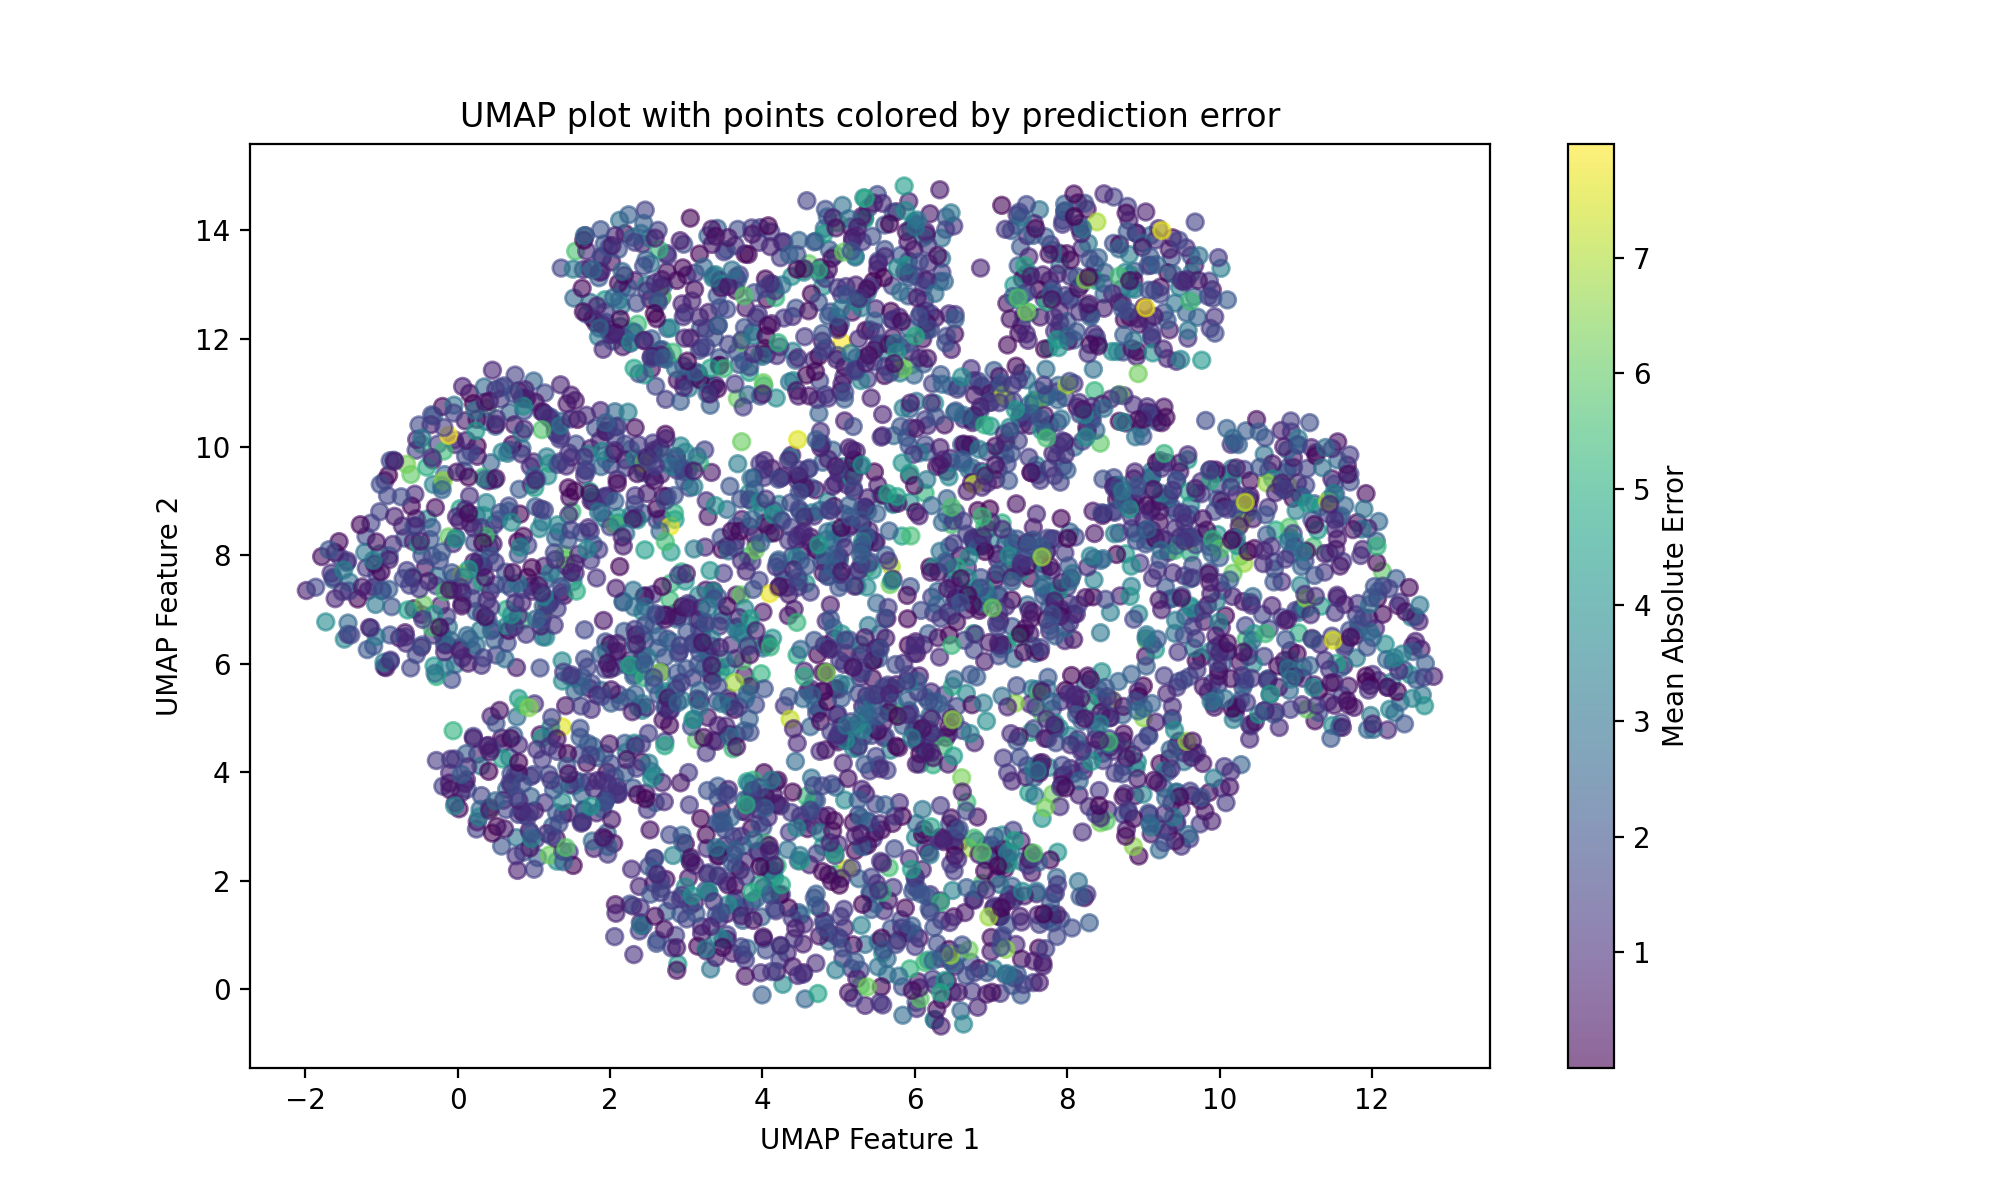

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import umap

# Calculate the absolute error for each prediction
absolute_errors = np.abs(predicted_means - Y_test)

# Combine the features and the errors into one DataFrame for t-SNE/UMAP
tsne_features = X_test.copy()
tsne_features['absolute_error'] = absolute_errors

# Replace inf/-inf with NaN
tsne_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Option 1: Drop rows with NaNs (if they were inf/-inf)
tsne_features.dropna(inplace=True)


# Initialize UMAP. You can adjust n_neighbors and min_dist as needed.
reducer = umap.UMAP(n_neighbors=200, min_dist=1, n_components=2, random_state=42)

# Fit and transform the features (excluding the 'absolute_error' column)
embedding = reducer.fit_transform(tsne_features.drop('absolute_error', axis=1))

# Now, let's create the plot using UMAP results
plt.figure(figsize=(10,6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=tsne_features['absolute_error'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Mean Absolute Error')
plt.title('UMAP plot with points colored by prediction error')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.show()


UMAP WITH FEATURES AND STD

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


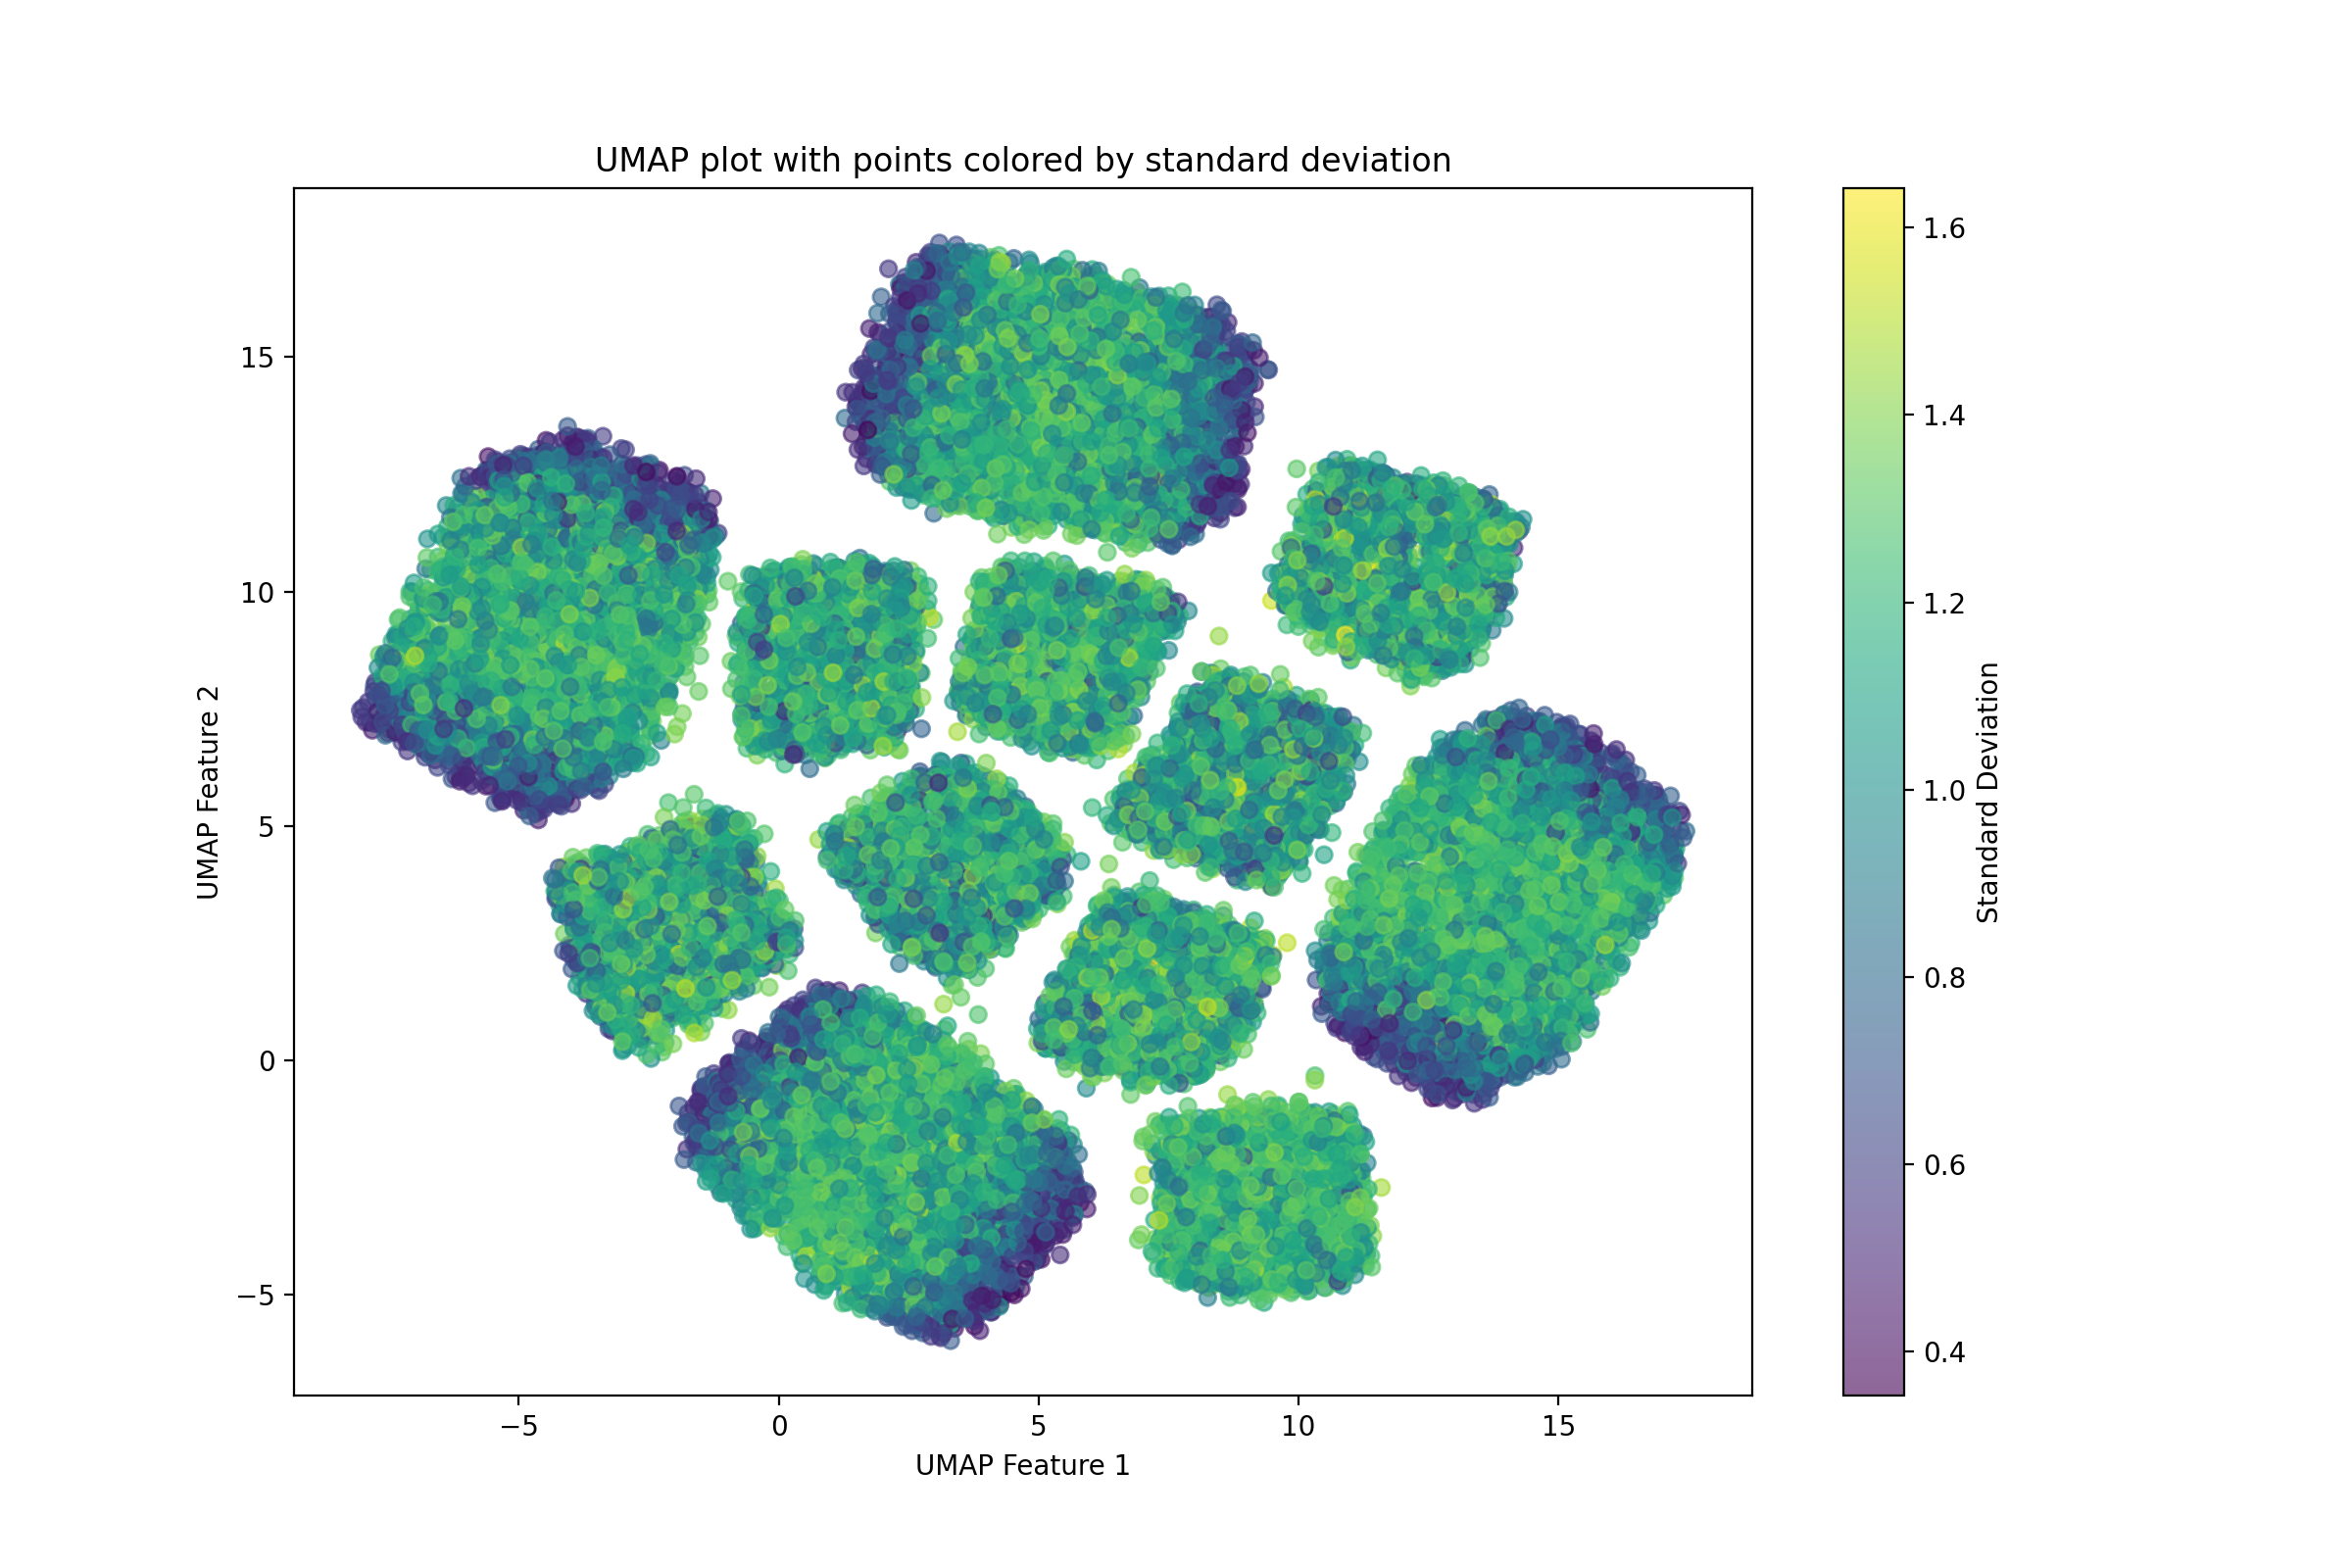

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Replace inf/-inf with NaN in your features
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check if there are any NaN values and handle them
if X_test.isnull().values.any():
    # Impute the NaNs or drop the rows/columns with NaN values.
    # Here we impute with the mean, but you might want to consider other imputation methods
    X_test = X_test.fillna(X_test.mean())

# Ensure no infinite values in predicted_variances before calculating the standard deviation
predicted_variances = np.where(np.isfinite(predicted_variances), predicted_variances, np.nan)
predicted_variances = np.nan_to_num(predicted_variances, nan=np.nanmean(predicted_variances))
predicted_std = np.sqrt(predicted_variances)

# Normalize your features to ensure they don't contain too large values
scaler = MinMaxScaler()
X_test_scaled = scaler.fit_transform(X_test)

# Combine the scaled features and the standard deviations into one DataFrame for UMAP
umap_features = pd.DataFrame(X_test_scaled, columns=X_test.columns)
umap_features['std_dev'] = predicted_std

# Initialize UMAP. You can adjust n_neighbors and min_dist as needed.
reducer = umap.UMAP(n_neighbors=200, min_dist=1, n_components=2, random_state=42)

# Fit and transform the features (excluding the 'std_dev' column)
embedding = reducer.fit_transform(umap_features.drop('std_dev', axis=1))

# Now, let's create the plot using UMAP results
plt.figure(figsize=(12,8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=umap_features['std_dev'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Standard Deviation')
plt.title('UMAP plot with points colored by standard deviation')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.show()


UMAP WITH TARGET AND MEAN ERROR

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


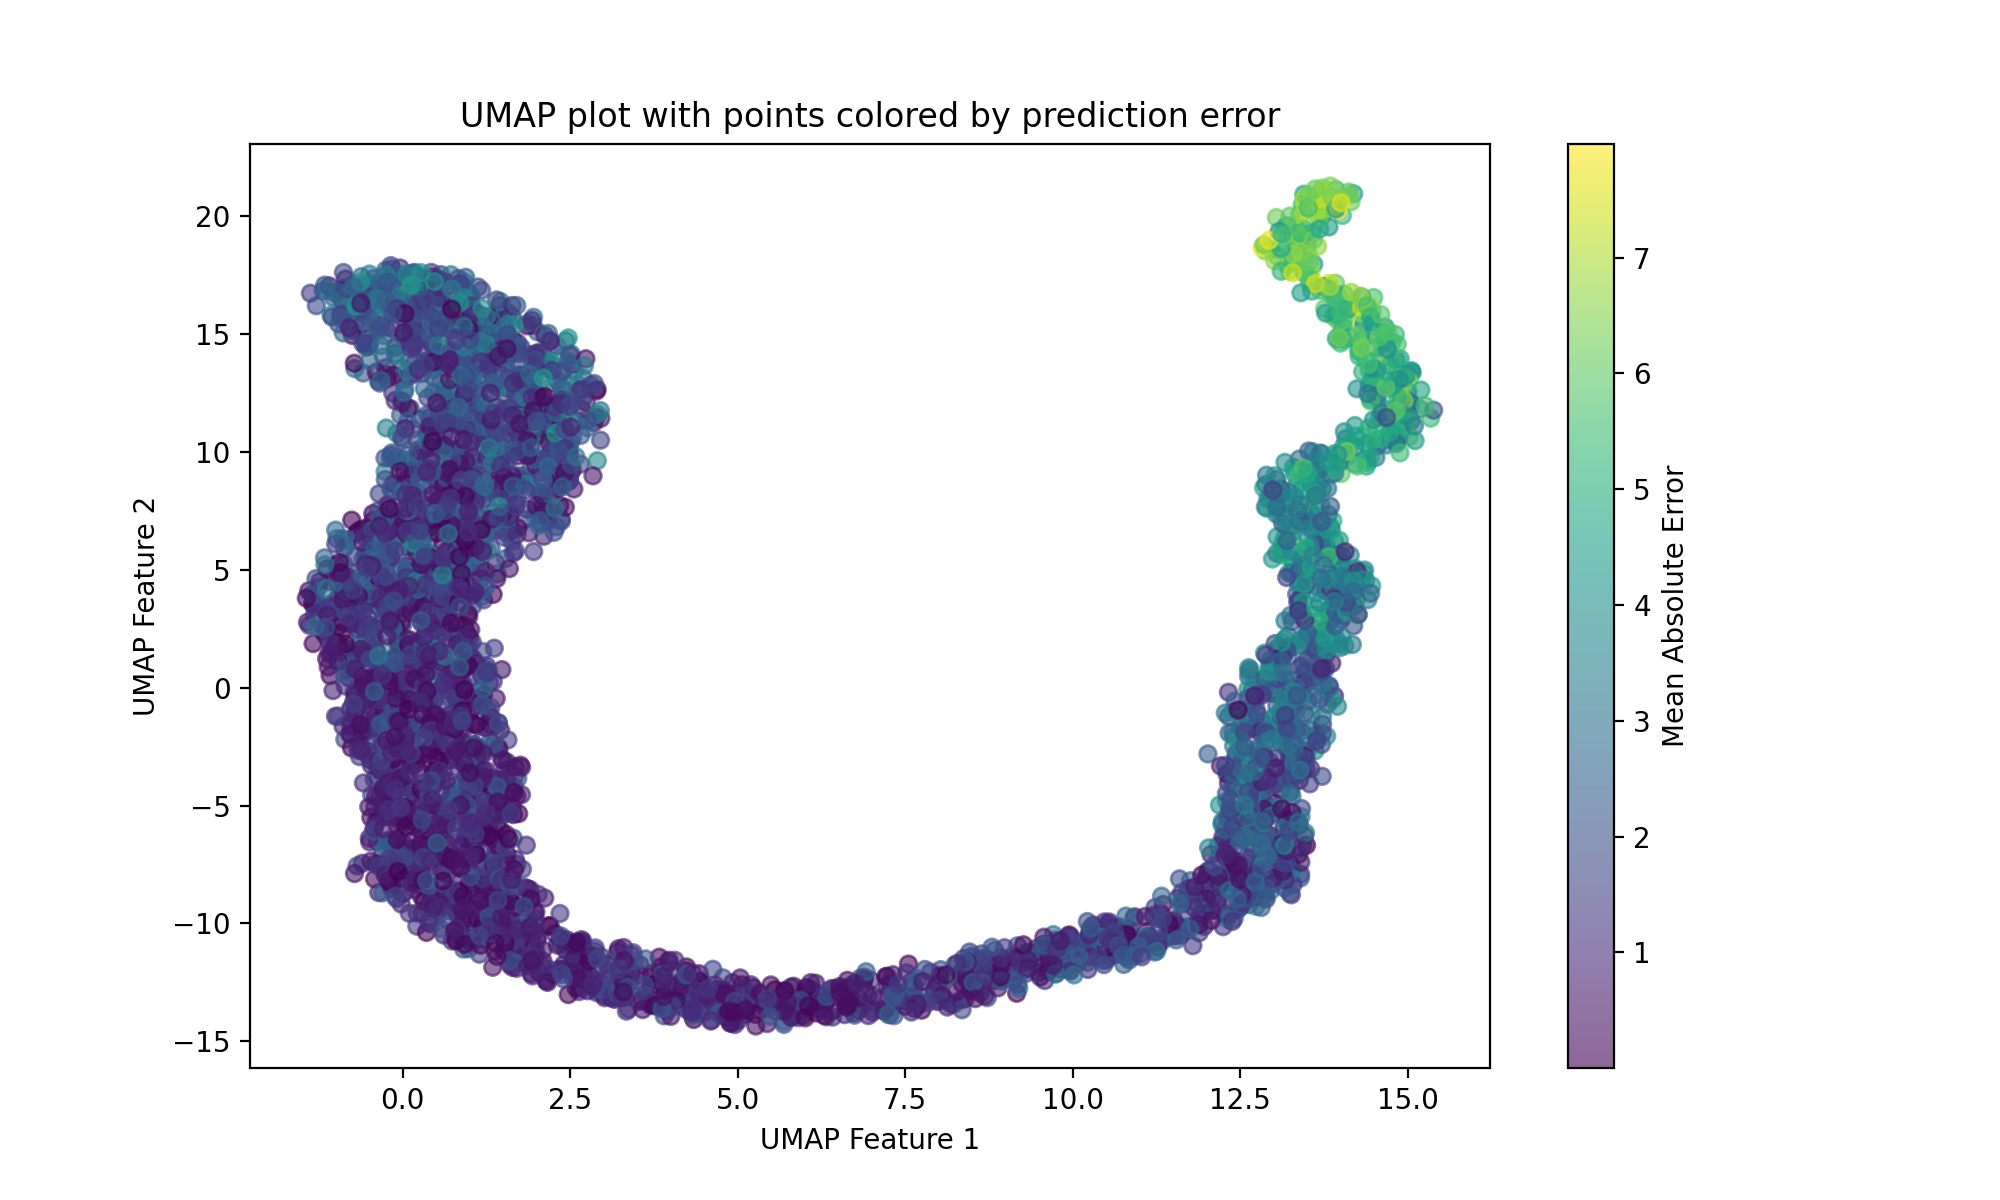

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import umap

# Calculate the absolute error for each prediction
absolute_errors = np.abs(predicted_means - Y_test)
f_t = pd.concat([X_test, Y_test], axis=1)

# Combine the features and the errors into one DataFrame for t-SNE/UMAP
tsne_features = f_t.copy()
tsne_features['absolute_error'] = absolute_errors

# Replace inf/-inf with NaN
tsne_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Option 1: Drop rows with NaNs (if they were inf/-inf)
tsne_features.dropna(inplace=True)


# Initialize UMAP. You can adjust n_neighbors and min_dist as needed.
reducer = umap.UMAP(n_neighbors=200, min_dist=1, n_components=2, random_state=42)

# Fit and transform the features (excluding the 'absolute_error' column)
embedding = reducer.fit_transform(tsne_features.drop('absolute_error', axis=1))

# Now, let's create the plot using UMAP results
plt.figure(figsize=(10,6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=tsne_features['absolute_error'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Mean Absolute Error')
plt.title('UMAP plot with points colored by prediction error')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.show()


UMAP WITH TARGET AND STD

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


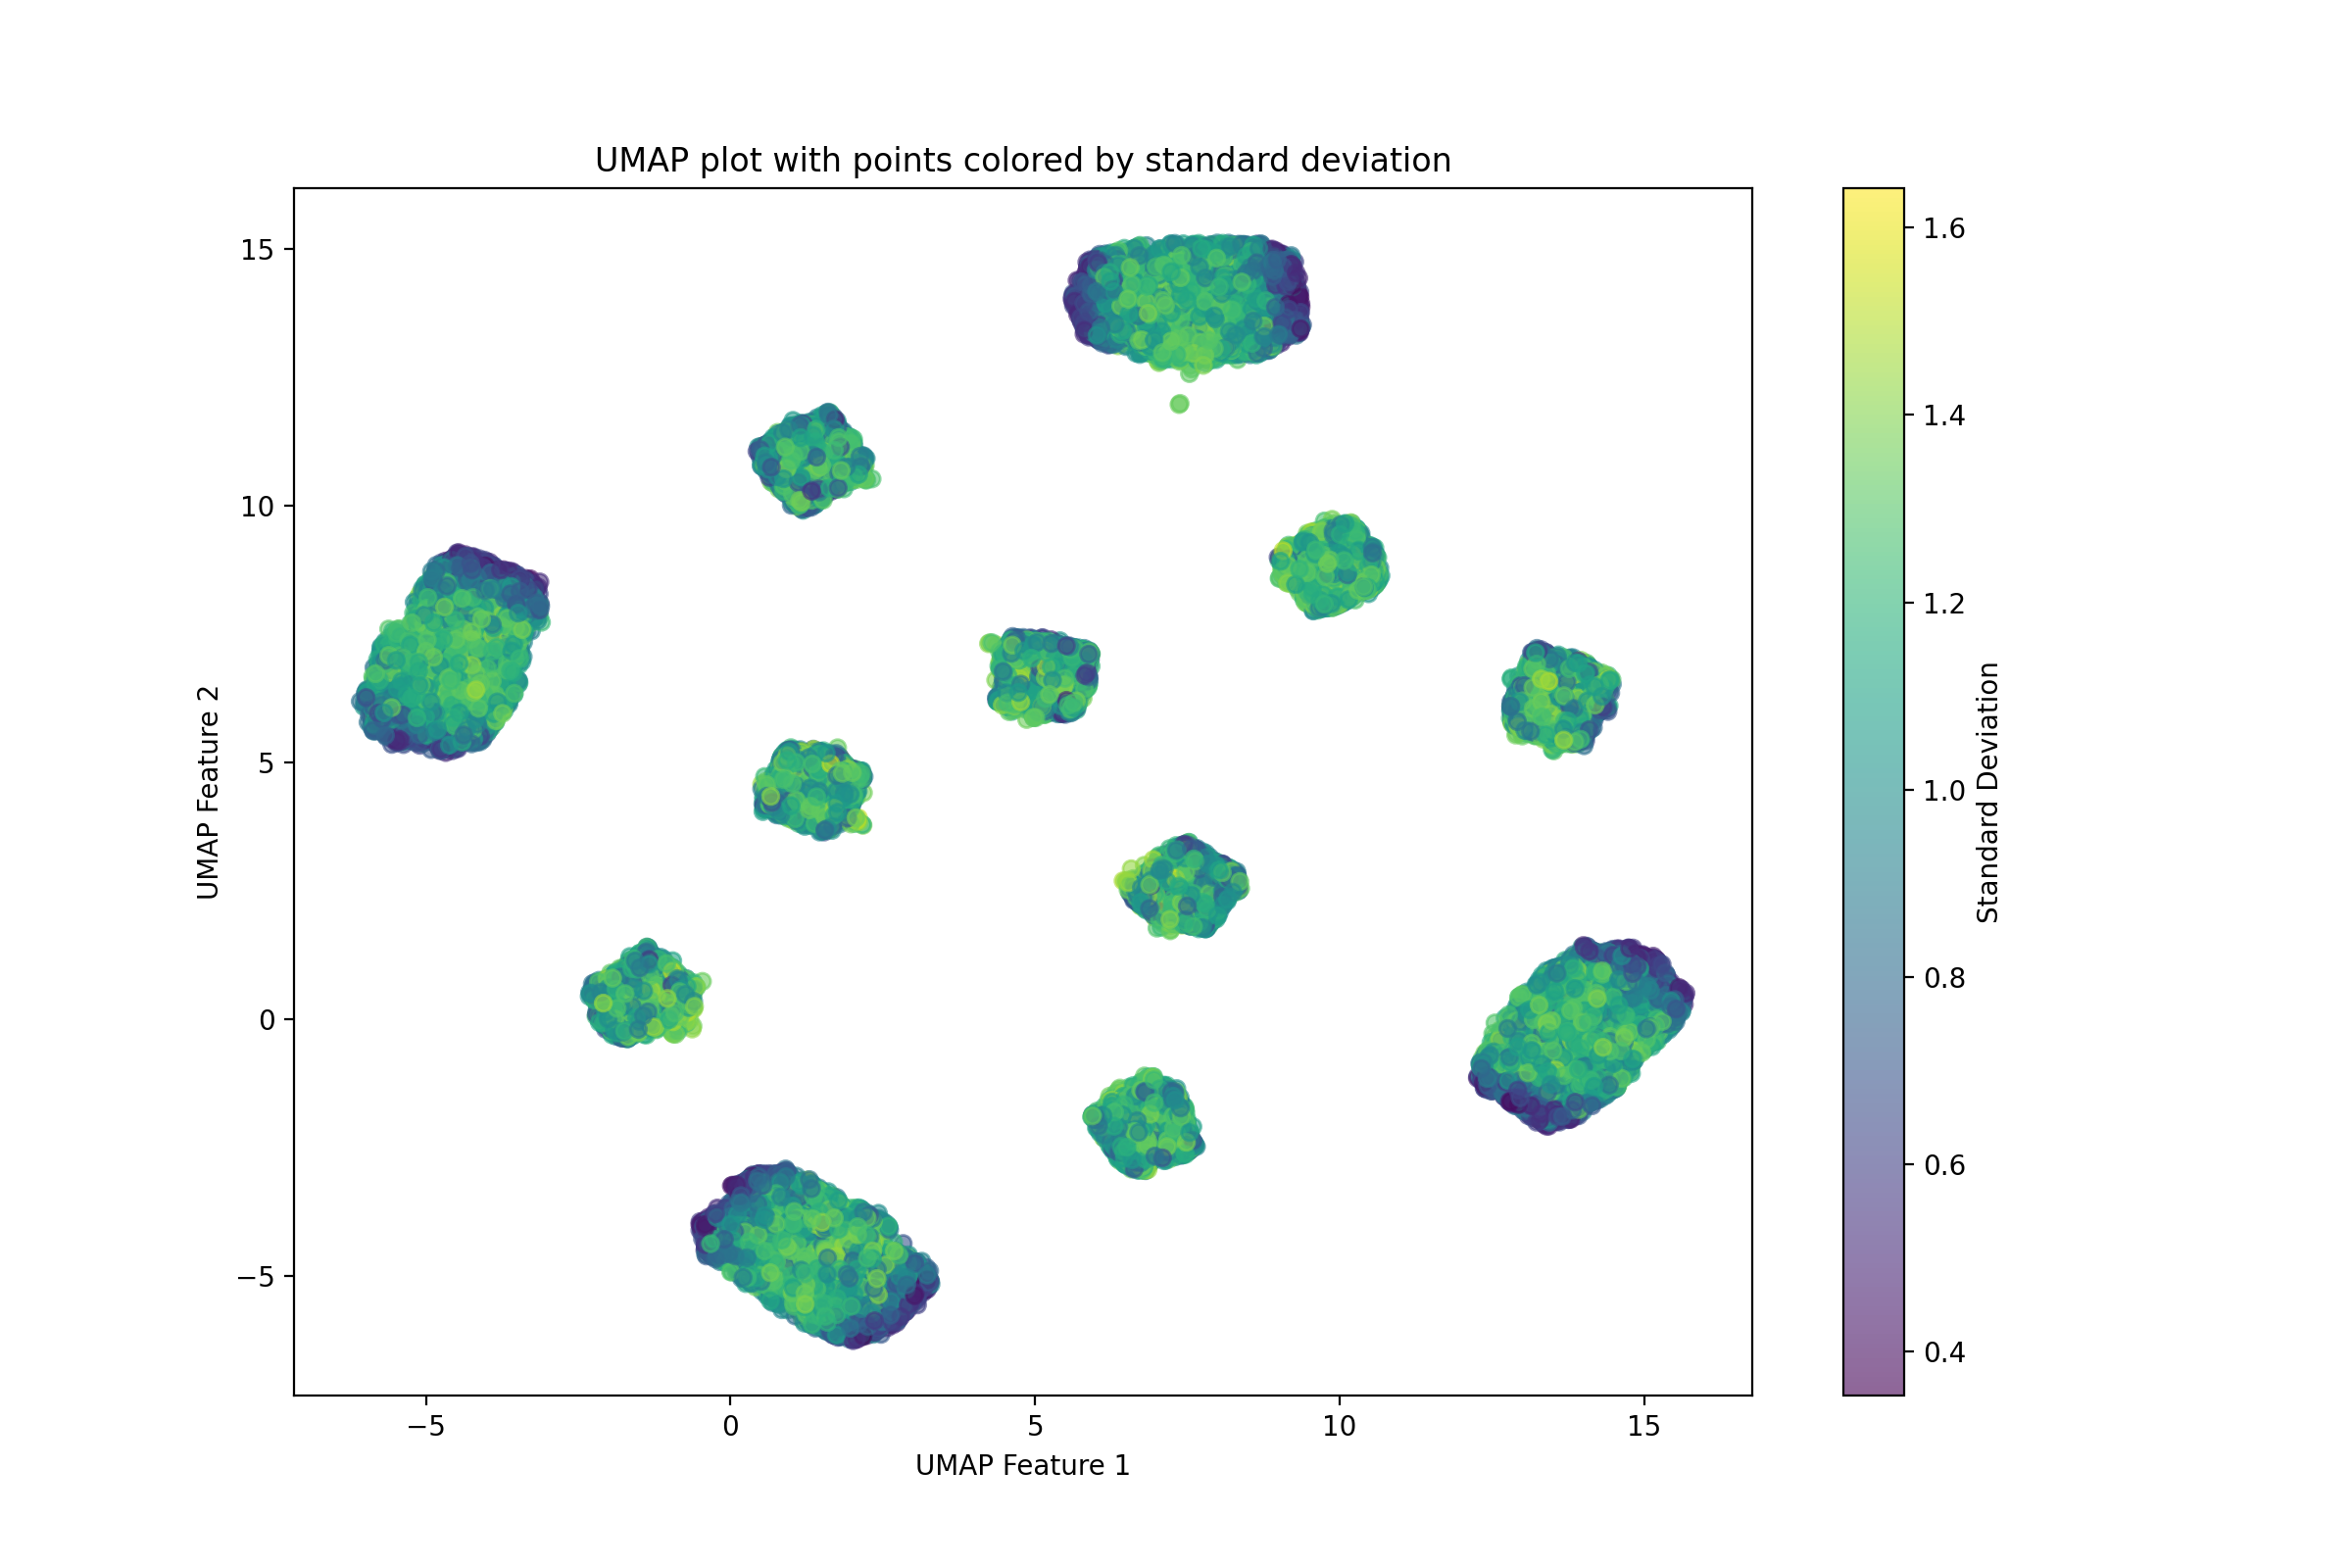

In [19]:
# Assuming `X_test` and `Y_test` are pandas DataFrames and `predicted_variances` is a numpy array

# Replace inf/-inf with NaN and then drop or impute NaN values for both X_test and Y_test
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
Y_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Assuming you want to impute NaN values, do it for both
X_test = X_test.fillna(X_test.mean())
Y_test = Y_test.fillna(Y_test.mean())

# Combine X_test and Y_test into a single DataFrame
combined_data = pd.concat([X_test, Y_test], axis=1)

# Normalize your features to ensure they don't contain too large values
scaler = MinMaxScaler()
combined_data_scaled = scaler.fit_transform(combined_data)

# Combine the scaled features into one DataFrame for UMAP
umap_features = pd.DataFrame(combined_data_scaled, columns=combined_data.columns)

# Initialize UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

# Fit and transform the features
embedding = reducer.fit_transform(umap_features)

# Ensure no infinite values in predicted_variances before calculating the standard deviation
predicted_variances = np.where(np.isfinite(predicted_variances), predicted_variances, np.nan)
predicted_variances = np.nan_to_num(predicted_variances, nan=np.nanmean(predicted_variances))
predicted_std = np.sqrt(predicted_variances)

# Add standard deviation to the UMAP features for coloring the plot
umap_features['std_dev'] = predicted_std

# Now, let's create the plot using UMAP results
plt.figure(figsize=(12,8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=umap_features['std_dev'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Standard Deviation')
plt.title('UMAP plot with points colored by standard deviation')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.show()
